# Google Analytics Google Merchandise eCommerce Store

In [1]:
#Utitlities
import random
import json
import datetime
from datetime import datetime, timedelta
import pycountry
from scipy.stats import beta, gamma, invgamma, norm

#Data Manipulation
import pandas as pd
import numpy as np

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

#Preprocessing
from sklearn.preprocessing import Imputer, MinMaxScaler

#testing and validation
from sklearn.cross_validation import train_test_split, cross_val_score, KFold

#Models
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import lifetimes
from fbprophet import Prophet
import statsmodels.api as sm
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.estimation import *

#Metrics
from sklearn.metrics import mean_squared_error

#display options
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'image.cmap': 'coolwarm'})
pd.set_option('display.max_columns', 500)
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

#decision tree imports
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [2]:
train_file = './all/train.csv'

In [3]:
np.random.seed(42)
train_df = pd.read_csv(train_file, header=0)

- **fullVisitorId** - A unique identifier for each user of the Google Merchandise Store.


- **channelGrouping** - The channel via which the user came to the Store.


- **date** - The date on which the user visited the Store.


- **device** - The specifications for the device used to access the Store.


- **geoNetwork** - This section contains information about the geography of the user.


- **sessionId** - A unique identifier for this visit to the store.


- **socialEngagementType** - Engagement type, either "Socially Engaged" or "Not Socially Engaged".


- **totals** - This section contains aggregate values across the session.


- **trafficSource** - This section contains information about the Traffic Source from which the session originated.


- **visitId** - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.


- **visitNumber** - The session number for this user. If this is the first session, then this is set to 1.


- **visitStartTime** - The timestamp (expressed as POSIX time).

## Data Preprocessing

In [4]:
# This function is to extract date features
def date_process(data):
    print('converting dates...')
    data['date'] = data['date'].astype(str) 
    data["date"] = data["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:]) 
    data["date"] = pd.to_datetime(data["date"])
    data["weekday"] = data['date'].dt.weekday
    data["year"] = data['date'].dt.year
    data["day"] = data['date'].dt.day
    data["month"] = data['date'].dt.month
    print('converting dates completed...')
    return data

def unpack(data):
    print('flattening json cols...')
    json_cols = ['totals','device','geoNetwork','trafficSource']
    dfs = [data[['sessionId',col]].set_index('sessionId')[col].apply(lambda x: pd.Series(json.loads(x))) for col in json_cols]
    df1 = dfs.pop(0)
    unpacked = df1.join(dfs)
    del dfs
    del df1
    unpacked.replace(['not available in demo dataset','(not set)','(not provided)'],np.nan, inplace=True)
    unpacked['transactionRevenue'].fillna(0, inplace=True)
    unpacked.transactionRevenue = unpacked.transactionRevenue.astype(np.float)
    unpacked.transactionRevenue = unpacked.transactionRevenue.apply(lambda x: x/1000000)
    unpacked.drop([col for col in unpacked.columns if ((unpacked[col].isnull().sum())==(unpacked.shape[0]))], axis=1, inplace=True)
    unpacked.drop('adwordsClickInfo', axis=1, inplace=True)
    data.drop(json_cols, axis=1, inplace=True)
    data = pd.merge(data, unpacked, right_index=True, left_on='sessionId')
    del unpacked
    print('finished unpacking json data...')
    return data

def clean_data(data):
    print('beginning data cleaning process...')
    data = unpack(data)
    #drop cols that don't add value, have too many nulls, etc
    drop_cols = ['campaign','campaignCode','keyword','adContent','city','region','metro','referralPath','networkDomain','operatingSystem','source','medium','isTrueDirect','socialEngagementType']
    data.drop(drop_cols, axis=1, inplace=True)
    #convert date to datetime and extract month, day, year into new features
    data = date_process(data)
    #encode binary variables
    data['bounces'] = 1*(data['bounces']=='1')
    data['newVisits'] = 1 * (data['newVisits']=='1')
    data['isMobile'] = 1*(data['isMobile'])
    #impute most frequent observation
    data.loc[data.subContinent.isnull(),'country'] = 'United States'
    data.loc[data.subContinent.isnull(),'continent'] = 'Americas'
    data.loc[data.subContinent.isnull(),'subContinent'] = 'North America'
    data.loc[data['browser'].isnull(),'browser']='Chrome'
    #convert data types
    data['hits'] = pd.to_numeric(data['hits'])
    data['pageviews'] = pd.to_numeric(data['pageviews'])
    data['visits'] = pd.to_numeric(data['visits'])
    data.loc[data['pageviews'].isnull(),'pageviews'] = 3
    data.sort_values(['date'], inplace=True)
    print('data cleaning completed...')
    return data

In [5]:
train_df = clean_data(train_df)

beginning data cleaning process...
flattening json cols...
finished unpacking json data...
converting dates...
converting dates completed...
data cleaning completed...


In [6]:
train_df['conversion'] = 1*(train_df['transactionRevenue']>0)
train_df['returning'] = 1*(train_df['visitNumber']>1)
train_df.drop_duplicates(inplace=True)

In [7]:
train_df.sort_values(['fullVisitorId','date'], inplace=True)
train_df = train_df[~train_df.index.duplicated()]

In [8]:
train_df['visitSequence'] = train_df.groupby('fullVisitorId').cumcount()+1
firstvisit = train_df[train_df['visitSequence']==1].set_index('fullVisitorId').date
train_df['first_visit'] = train_df['fullVisitorId'].map(firstvisit)

In [9]:
firstchannel = train_df[train_df['visitSequence']==1].set_index('fullVisitorId').channelGrouping
train_df['first_touch'] = train_df['fullVisitorId'].map(firstchannel)

In [10]:
train_df.rename(columns={'convers"ion':'conversion'}, inplace=True)

In [11]:
conversions = train_df[train_df['conversion']==1].sort_values(['fullVisitorId','date'])
conversions = conversions.groupby(['fullVisitorId','date','sessionId'])['transactionRevenue'].sum()
conversions = conversions.reset_index()
conversions.sort_values('date',inplace=True)

In [12]:
order_sequence = conversions.groupby(['fullVisitorId','sessionId']).cumcount()+1
order_sequence.name = 'orderNumber'
conversions = conversions.join(order_sequence)

In [13]:
first_order_date = conversions[conversions.orderNumber==1].set_index('fullVisitorId').date
first_order_date.name = "firstOrderDate"
customer_ids = conversions.fullVisitorId.unique()
customers = train_df[train_df.fullVisitorId.isin(customer_ids)]
customers = customers.join(first_order_date, on='fullVisitorId')
customers['daysDelta'] = (customers['first_visit'] - customers['firstOrderDate']).dt.days
customers['daysDelta'] = abs(customers['daysDelta'])
customers['weeksDelta'] = np.ceil(customers['daysDelta']/7)
customers['monthsDelta'] = np.ceil(customers['daysDelta']/30)

# Goals 

1. Which customers are most valuable? 
    - Do any marketing channels bring in higher quality leads than others?
    - Do they have anything in common? (Location/device/spending behavior/ cohort) 


2. Forecast, customer LTV

3. Value business based on expected future revenue

4. With LTV results, rank customers by quartile and see if the top quartile have anything in common

## Revenue Distribution

In [14]:
train_df.transactionRevenue.sum()

1539518.7500000002

In [15]:
len(train_df[train_df.conversion==1].fullVisitorId.unique())

10362

In [16]:
train_df[train_df.conversion==1].shape[0]

11516

In [17]:
train_df[train_df.conversion==1].transactionRevenue.describe()

count    11516.000000
mean       133.685199
std        448.265636
min          0.010000
25%         24.867500
50%         49.385000
75%        107.517500
max      23129.500000
Name: transactionRevenue, dtype: float64

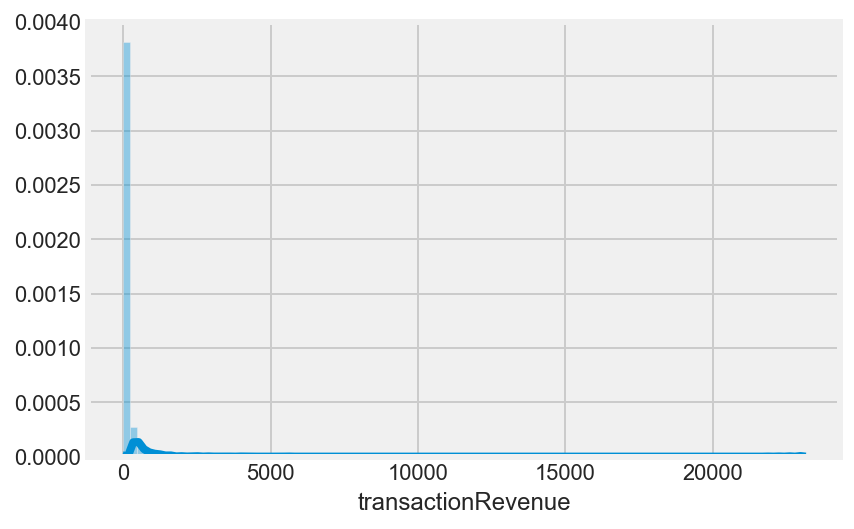

In [18]:
sns.distplot(train_df[train_df.conversion==1]['transactionRevenue'], bins=100)

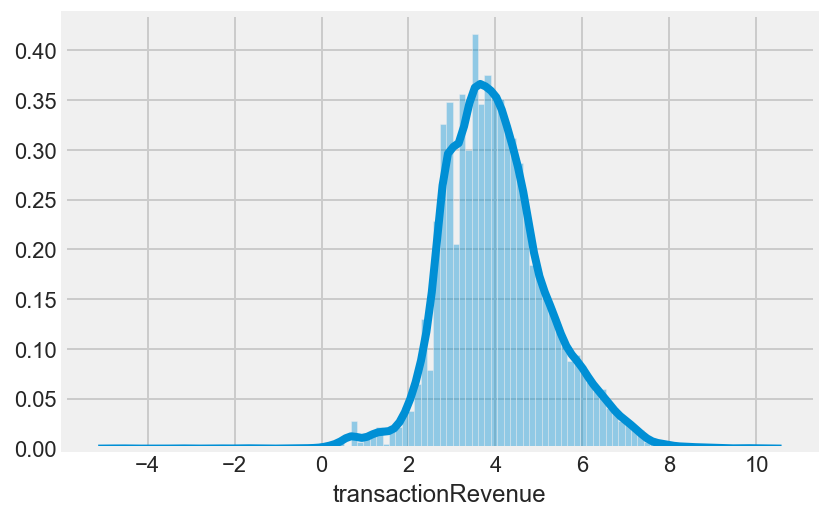

In [19]:
sns.distplot(np.log(train_df[train_df.conversion==1]['transactionRevenue']), bins=100)

In [20]:
revenue = train_df.groupby([pd.Grouper(key='date', freq='D')])['transactionRevenue'].sum()

In [21]:
data = [go.Scatter(x=revenue.index, 
               y=revenue.rolling(window=7).mean(), 
               name = 'Daily Revenue',
               mode = 'lines',
              )]

layout = dict(
    title='Time Series with Rangeslider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename = "Time Series with Rangeslider")

In [22]:
visits = train_df.groupby([pd.Grouper(key='date', freq='D'),'channelGrouping'])['visits'].sum()
visits = visits.reset_index()
dfs = {channel:visits[visits['channelGrouping']==channel] for channel in visits.channelGrouping.unique()}
data = [go.Scatter(x=data.date, 
               y=data.visits.rolling(window=7).mean(), 
               name = key,
               mode = 'lines',
              ) 
 for key, data in dfs.items()]

## Traffic by Channel over past year

In [23]:
layout = dict(
    title='Time Series with Rangeslider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename = "Time Series with Rangeslider")

In [24]:
revenue = train_df.groupby([pd.Grouper(key='date', freq='D'),'channelGrouping'])['transactionRevenue'].sum()

In [25]:
revenue = revenue.reset_index()
dfs = {channel:revenue[revenue['channelGrouping']==channel] for channel in revenue.channelGrouping.unique()}
data = [go.Scatter(x=data.date, 
               y=data.transactionRevenue.rolling(window=7).mean(), 
               name = key,
               mode = 'lines',
              ) for key, data in dfs.items()]

## Revenue by channel over the past year

In [26]:
layout = dict(
    title='Time Series with Rangeslider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename = "Time Series with Rangeslider")

In [27]:
conv_traffic = train_df.groupby([pd.Grouper(key='date', freq='D'),'conversion'])['visits'].sum().unstack('conversion')

In [28]:
conv_traffic = conv_traffic.reset_index()

In [29]:
data = [go.Scatter(x=conv_traffic.date, 
               y=conv_traffic.sum(axis=1).rolling(window=7).mean(), 
               name = 'Total Traffic',
               mode = 'lines',
              ),
       go.Scatter(x=conv_traffic.date, 
               y=conv_traffic[1].rolling(window=7).mean(), 
               name = 'Conversions',
               mode = 'lines',
              )]

## Total Traffic vs Conversions

In [30]:
layout = dict(
    title='Time Series with Rangeslider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename = "Time Series with Rangeslider")

In [31]:
ret_traffic = train_df.groupby([pd.Grouper(key='date', freq='D'),'returning'])['visits'].sum().unstack('returning')

In [32]:
ret_traffic = ret_traffic.reset_index()

In [33]:
data = [go.Scatter(x=ret_traffic.date, 
               y=ret_traffic[0].rolling(window=7).mean(), 
               name = 'New Traffic',
               mode = 'lines',
              ),
       go.Scatter(x=ret_traffic.date, 
               y=ret_traffic[1].rolling(window=7).mean(), 
               name = 'Returning',
               mode = 'lines',
              )]

In [34]:
layout = dict(
    title='Time Series with Rangeslider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename = "Time Series with Rangeslider")

In [35]:
train_df.country = train_df.country.str.replace('&','and')

In [36]:
def get_country_code(country):
    if country == 'Russia':
        return 'RUS'
    try:
        return pycountry.countries.get(name=country).alpha3
    except:
        return np.nan

In [37]:
train_df['country_code'] = train_df['country'].apply(get_country_code)

In [38]:
country_rev = train_df.groupby('country_code')['transactionRevenue'].sum()
country_rev.sort_values(ascending=False, inplace=True)

## Revenue by location

In [39]:
data = [ dict(
        type = 'choropleth',
        locations = country_rev.index,
        z = country_rev,
        text = country_rev.index,
        colorscale = [[0,"rgb(5, 10, 172)"],[0.001,"rgb(40, 60, 190)"],[0.005,"rgb(70, 100, 245)"],\
            [0.01,"rgb(90, 120, 245)"],[0.05,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '$',
            title = 'gStore Global Sales'),
      ) ]

layout = dict(
    title = 'Global Sales',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, validate=False, filename='d3-world-map' )

## Cohort Analysis



In [40]:
print('Ratio of customers who purchase on first day: %f' % (customers[(customers.conversion==1)&(customers.daysDelta==0)].shape[0]/conversions.shape[0]))
print('Ratio of customers who purchase in first week: %f' % (customers[(customers.conversion==1)&(customers.daysDelta<7)].shape[0]/conversions.shape[0]))
print('Ratio of customers who made a repeat purchase: %f' % ((len(conversions[conversions.orderNumber>1].fullVisitorId.unique()))/len(conversions.fullVisitorId.unique())))

Ratio of customers who purchase on first day: 0.702240
Ratio of customers who purchase in first week: 0.849861
Ratio of customers who made a repeat purchase: 0.000483


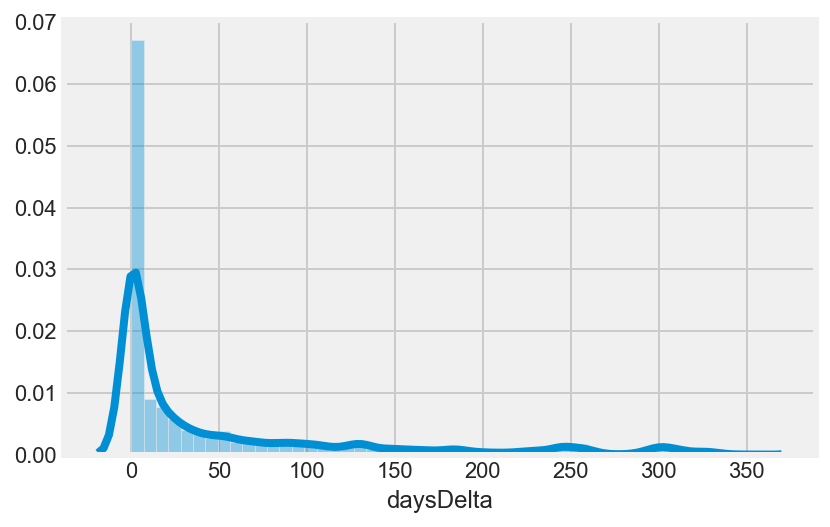

In [41]:
sns.distplot(customers['daysDelta'])

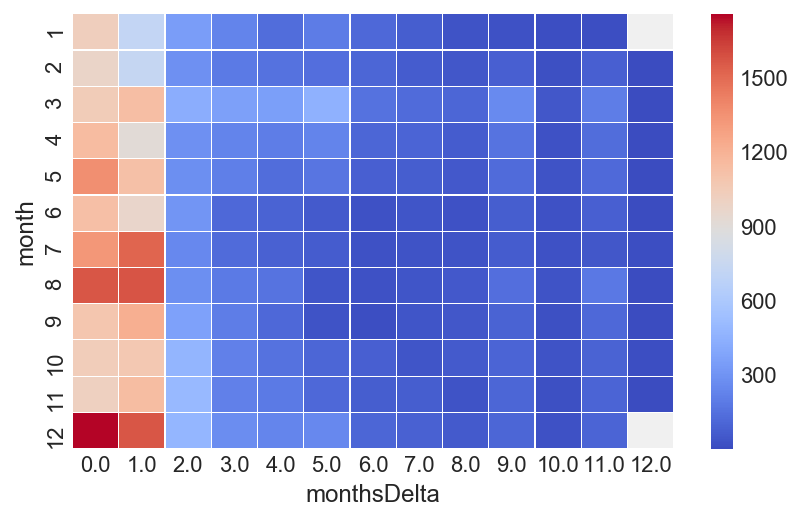

In [42]:
time_to_conv = pd.pivot_table(data=customers, index='month', columns='monthsDelta', values='fullVisitorId', aggfunc='count')
sns.heatmap(time_to_conv, linecolor='white', linewidths=0.1, cmap='coolwarm')

In [43]:
time_to_conv = pd.pivot_table(data=customers, index='isMobile', columns='monthsDelta', values='fullVisitorId', aggfunc='count')

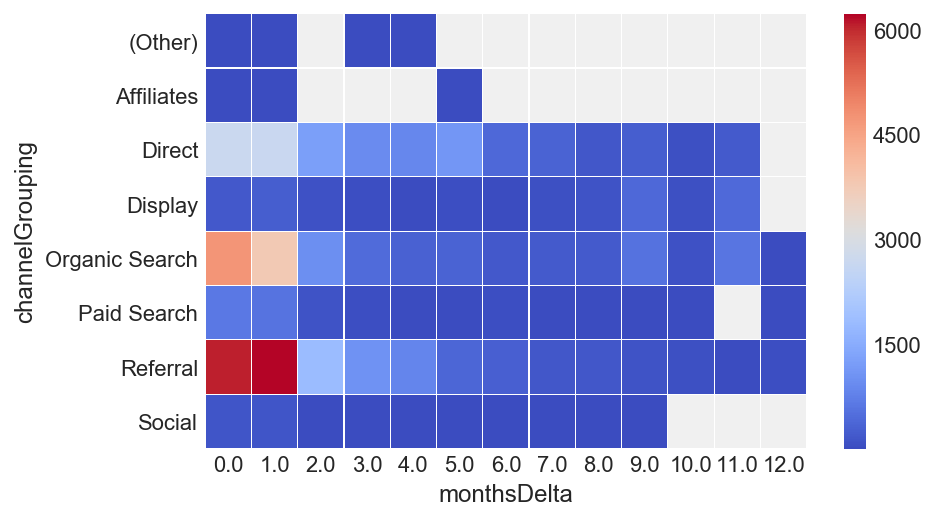

In [44]:
time_to_conv = pd.pivot_table(data=customers, index='channelGrouping', columns='monthsDelta', values='fullVisitorId', aggfunc='count')
sns.heatmap(time_to_conv, linecolor='white', linewidths=0.1, cmap='coolwarm')

Change the below to look at first purchase to second purchase time

In [45]:
return_traffic = train_df[['date','fullVisitorId','isMobile','visitSequence','first_visit','first_touch']]
return_traffic['cohort'] = return_traffic.first_visit.dt.to_period('M')
return_traffic['period'] = return_traffic.date.dt.to_period('M')
cohorts = return_traffic.groupby(['cohort','period'])['fullVisitorId'].nunique()
periods = cohorts.groupby(level=0).cumcount()+1
cohorts = pd.concat([periods,cohorts],axis=1)
cohorts.columns = ['number','users']
cohort_size = cohorts['users'].groupby(level=0).first()
cohorts = cohorts.reset_index()
cohorts.drop('period',axis=1, inplace=True)
cohorts.set_index(['cohort','number'], inplace=True)
user_retention = cohorts['users'].unstack(0)

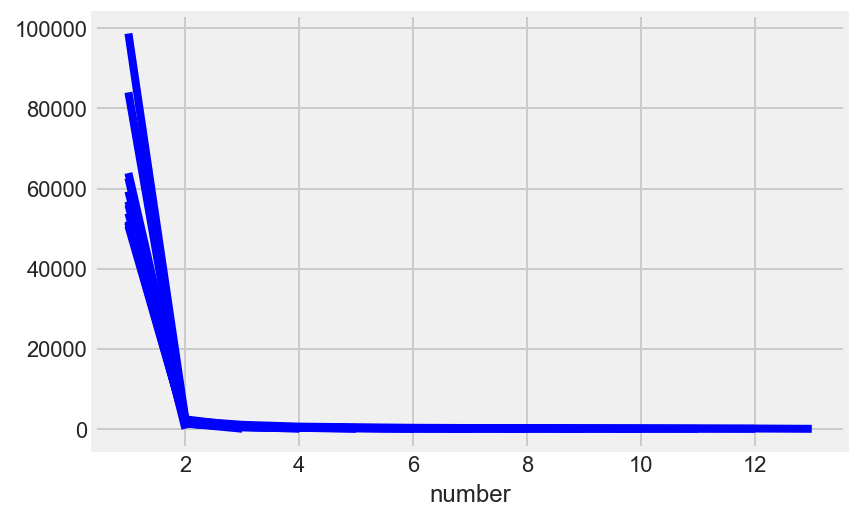

In [46]:
user_retention.plot(c='blue', legend=False)

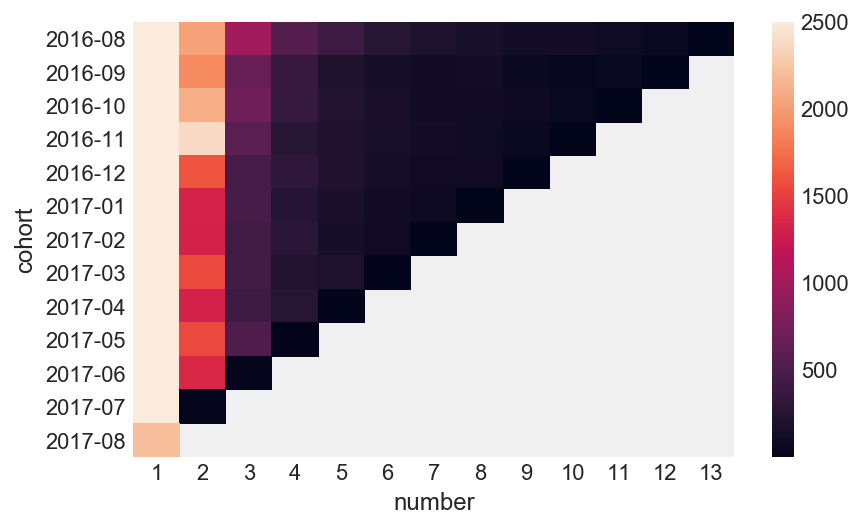

In [47]:
sns.heatmap(user_retention.T, vmax=2500)

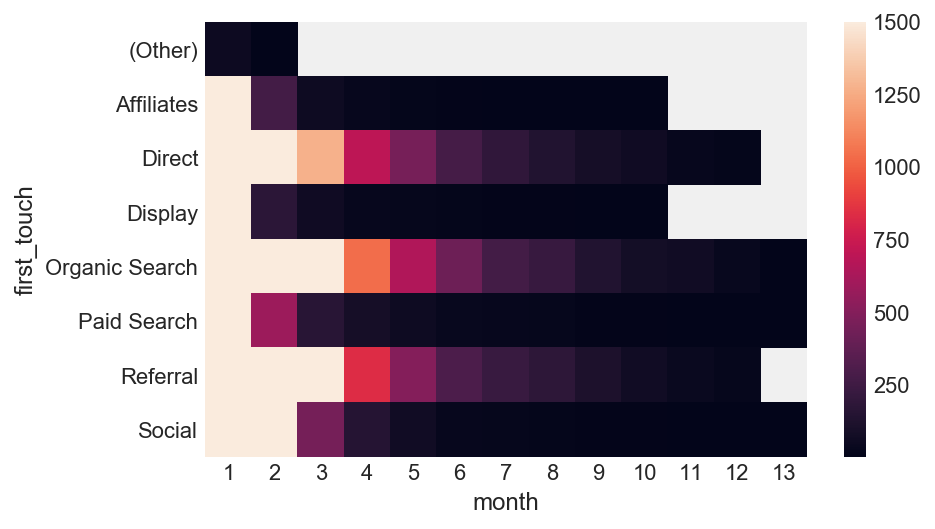

In [48]:
cohorts = return_traffic.groupby(['cohort','first_touch','period'])['fullVisitorId'].nunique()
periods = cohorts.groupby(level=[0,1]).cumcount()+1
cohorts = pd.concat([periods,cohorts],axis=1)
cohorts.columns = ['month','users']
cohort_size = cohorts['users'].groupby(level=0).first()
cohorts = cohorts.reset_index()
channel_retention = pd.pivot_table(data=cohorts,index='first_touch',columns='month',values='users', aggfunc=np.sum)
sns.heatmap(channel_retention, vmax=1500);

## LTV Analysis

Customers buy stochastically according to a Poisson distribution with purchasing rate .  After each purchase the customer has % chance of becoming inactive.  Therefore, the time period at which a customer becomes inactive is distributed as a shifted geometric distribution.  The customer-base is heterogeneous across those two parameters such that we can assume a gamma and beta distribution respectively.  Lastly we assume that  and  across customers are jointly independent.  This makes some of the math later on much easier.

This class of models try to quantify customer behavior under a non-contractual setting where we don't know when customers become inactive but rather assign a percentage confidence that we believe they are dead.  In contrast, another class of models are designed for contractual settings and have been successfully applied to other businesses such as the telecommunication industry where a customer has to tell you that they're ending their relationship.
For example, a large number of subscriber-based firms like Netflix often report and describe their churn rate or customer turnover.  CLV is much simpler to quantify on that scale but for a normal product-selling firm, this is much more difficult as were not sure when a customer has decided to terminate the relationship.

Having a model that can describe customer deaths and purchases over time is much more effective at inferring their future purchases and the subsequent aggregation into expected total sales than a naive "oh I expect goods sale to grow at 2% in the next year".  This is shown in details later on with some simple plots.

In [49]:
orders = conversions.groupby(['fullVisitorId','date']).transactionRevenue.sum().reset_index()

The models presented in _lifetimes_ measure customer's __repeat__ purchase behaviors based on his/her recency $x_t$, frequency $x$ and analysis period $T$.  Thus, each customer can be summarized into a vector $(x, t_x, T)$.  We can take our basic customer transaction list and parse it into a usable RF(M) dataframe for the model. We should use the function already made within _lifetimes_ called __summary_data_from_transaction_data()__:
- Recency ($t_x$) is calculated as the most recent transaction within $T$ less time of the first transaction
- Frequency ($x$) is number of repeat transactions the customer has made
- $T$ is equal to the end observation period less first purchase made by the customer (implied age)

The unit of time is in days

In [50]:
rfm = summary_data_from_transaction_data(orders, 
                                              customer_id_col='fullVisitorId', 
                                              datetime_col='date', 
                                              monetary_value_col='transactionRevenue', 
                                              observation_period_end='2017-08-01')

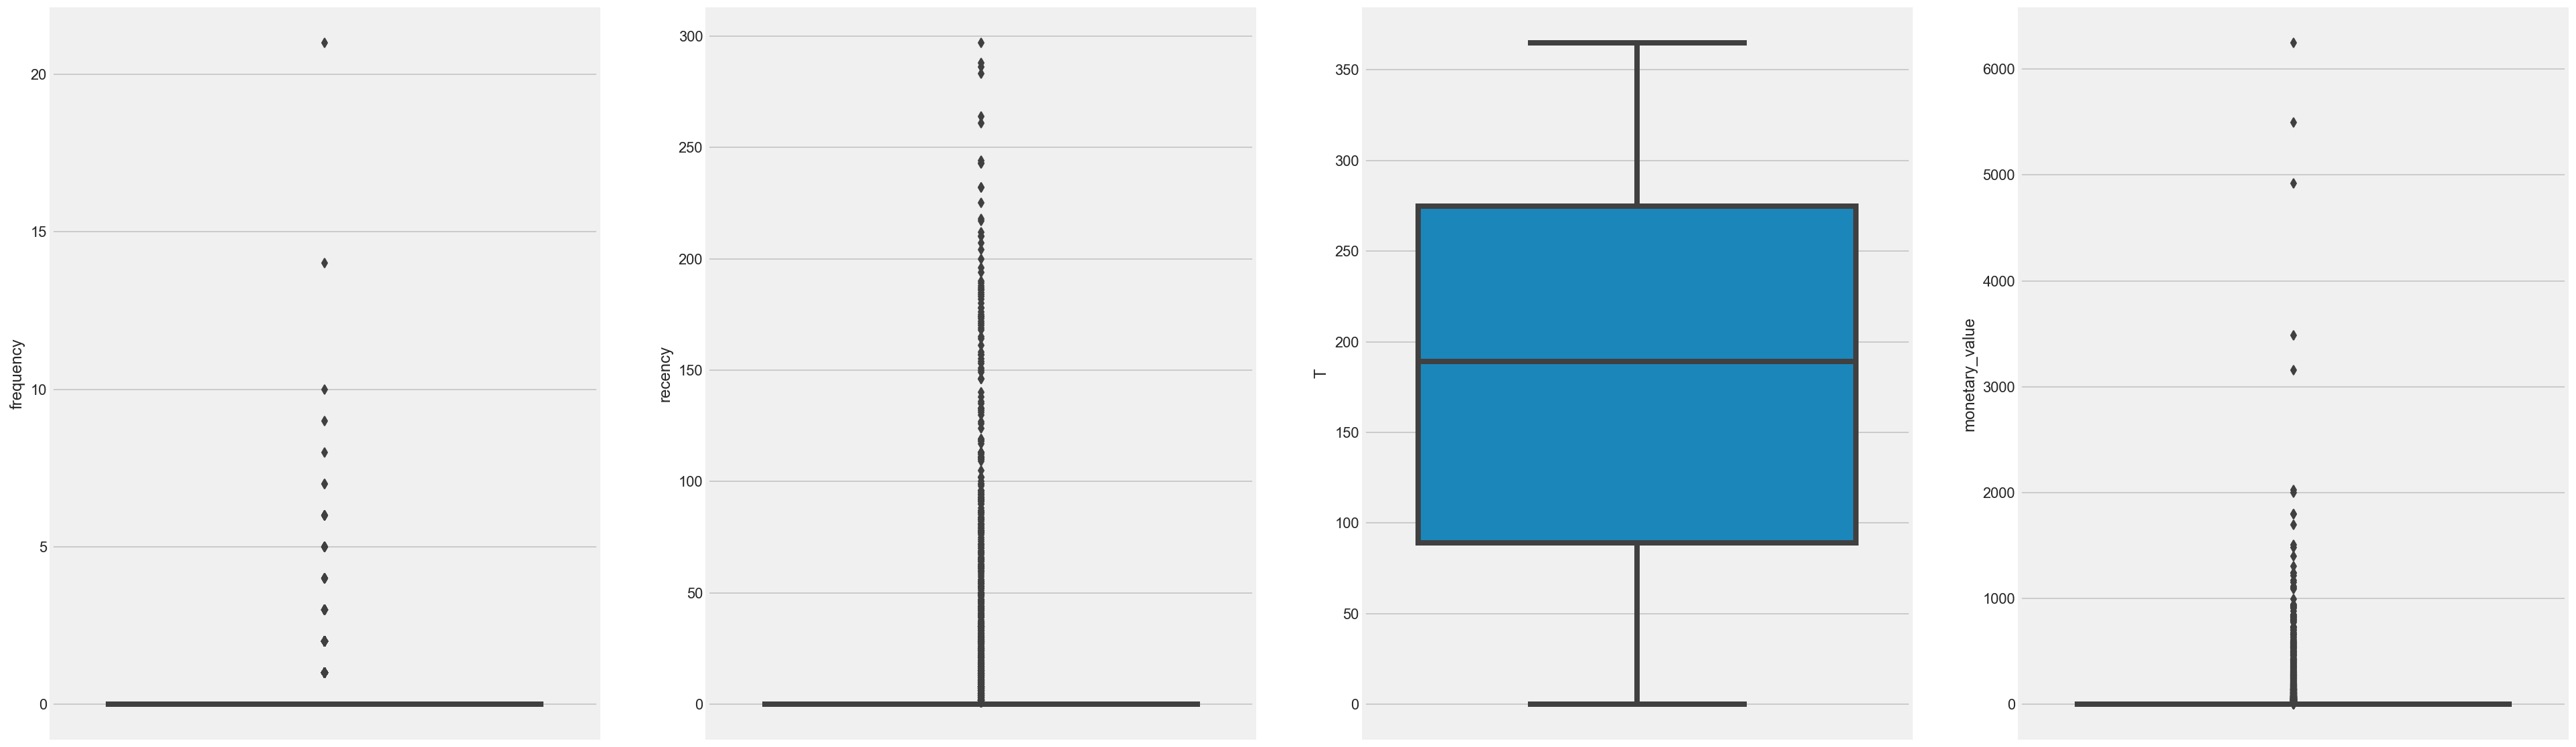

In [51]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(30,10))
sns.boxplot(data=rfm, x='frequency', orient='v', ax=ax1)
sns.boxplot(data=rfm, x='recency', orient='v', ax=ax2)
sns.boxplot(data=rfm, x='T', orient='v', ax=ax3)
sns.boxplot(data=rfm, x='monetary_value', orient='v', ax=ax4)

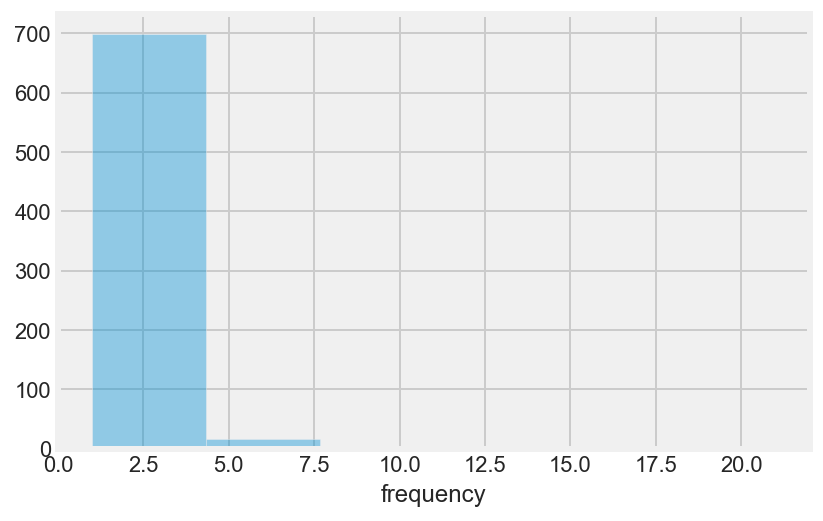

In [52]:
sns.distplot(rfm[rfm['frequency']>0]['frequency'], kde=False, bins=6)

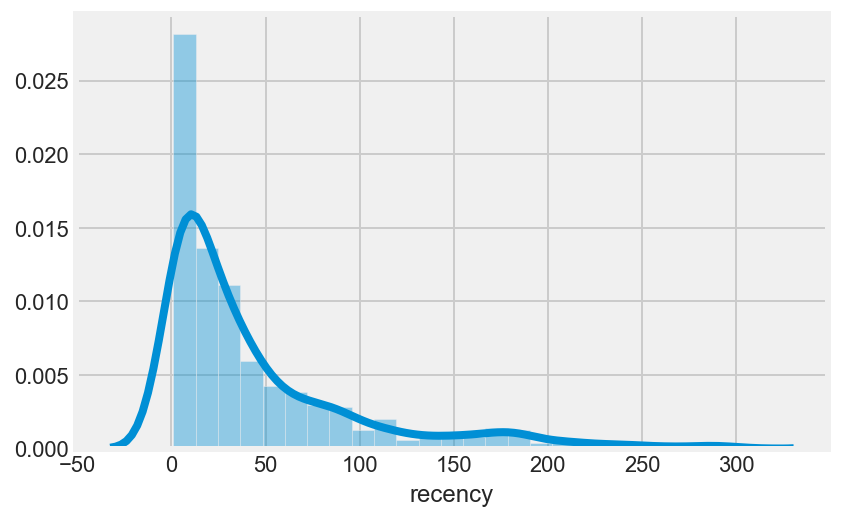

In [53]:
sns.distplot(rfm[rfm['recency']!=0]['recency'], kde=True, bins=25)

# BG/ NBD

At  every  moment, customers flips two coins: 

1. The first coin determines if the customer churns.

2. The second coin determines if the customer converts.

Every customer has their own set of coins

In [54]:
bgf = BetaGeoFitter(penalizer_coef=0.0005)
bgf.fit(rfm['frequency'], rfm['recency'], rfm['T'])

<lifetimes.BetaGeoFitter: fitted with 10362 subjects, a: 1.14, alpha: 5.23, b: 0.47, r: 0.02>

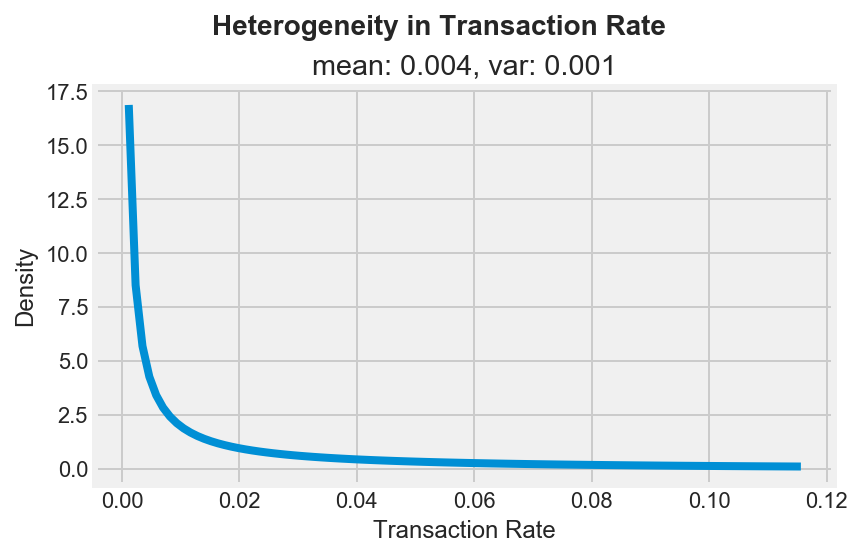

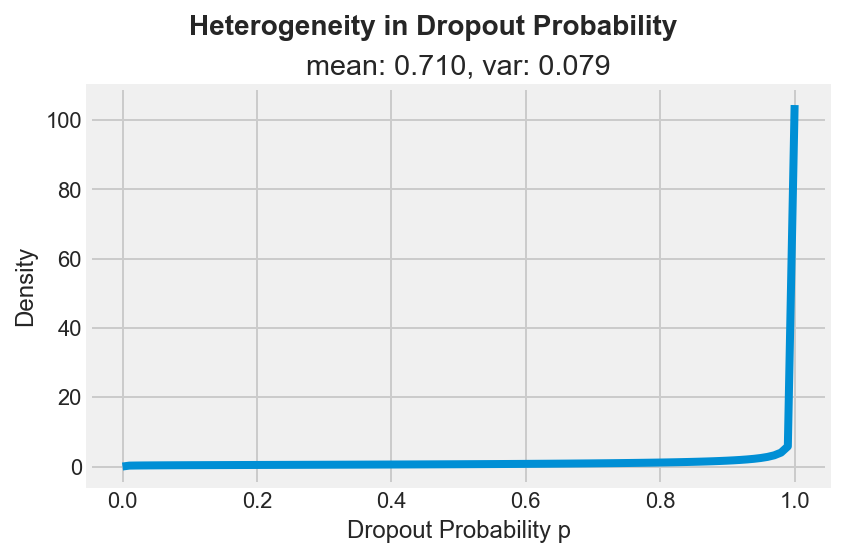

In [55]:
plot_transaction_rate_heterogeneity(bgf)
plot_dropout_rate_heterogeneity(bgf)

The distribution of the parameter $p$, the probability of not making another purchase, shows that the vast majority of customers churn after their furst purchase with very customers making repeat purchases. 

The distribution of the parameter $\lambda$, the transaction rate of each customer, falls between 0 and 0.5%. This seems too high? 

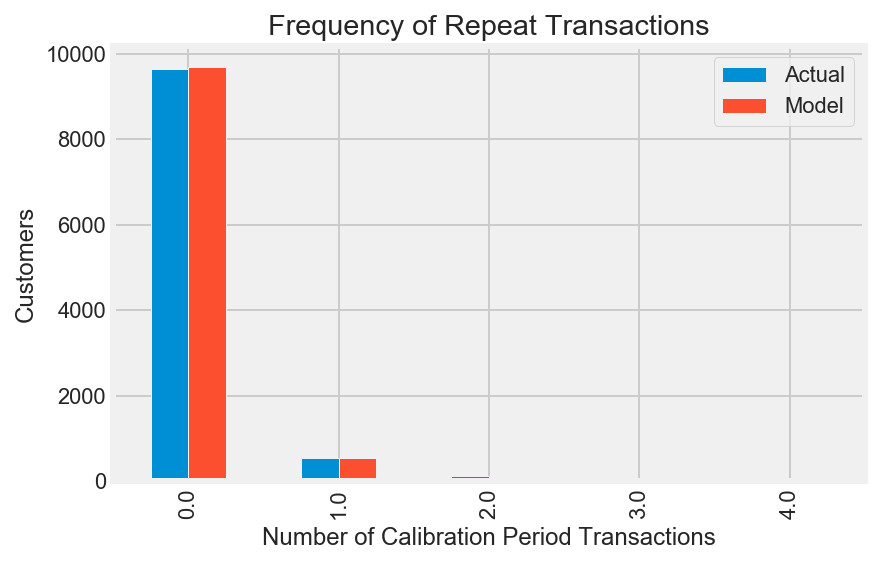

In [56]:
plot_period_transactions(bgf, max_frequency=5)

In [57]:
summary_cal_holdout = calibration_and_holdout_data(conversions, 'fullVisitorId', 'date', 
                                        calibration_period_end='2017-01-01')

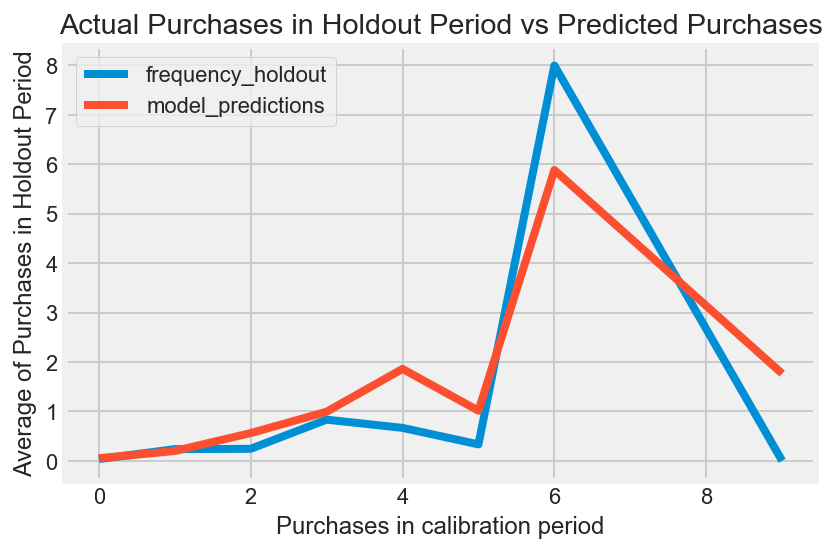

In [58]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, n=12)

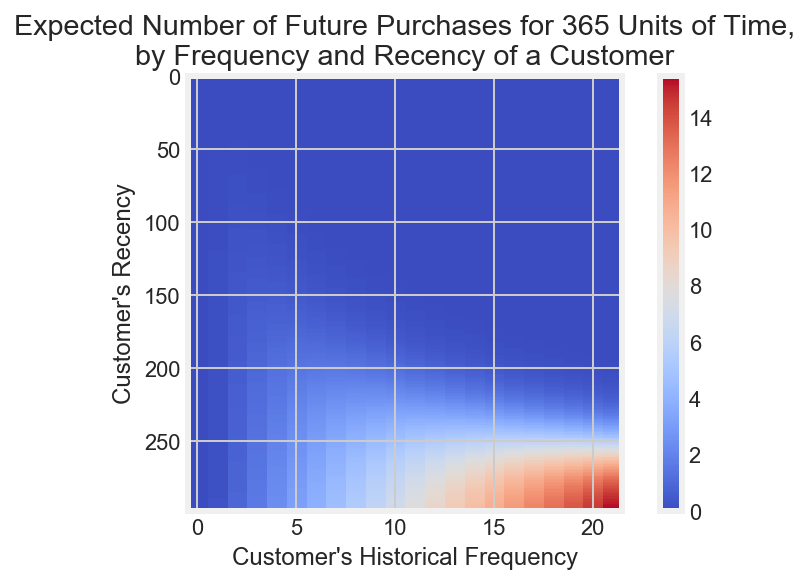

In [59]:
plot_frequency_recency_matrix(bgf, T=365, max_frequency=int(rfm.frequency.max()), max_recency=int(rfm.recency.max()))

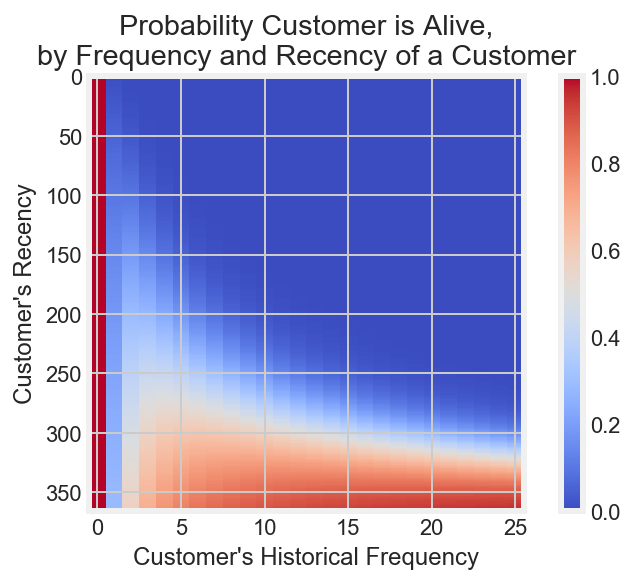

In [60]:
plot_probability_alive_matrix(bgf, max_frequency=25, max_recency=365)

In [61]:
t = 90
rfm['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, rfm['frequency'], rfm['recency'], rfm['T'])
top_8 = rfm.sort_values('predicted_purchases',ascending=False)[0:8]

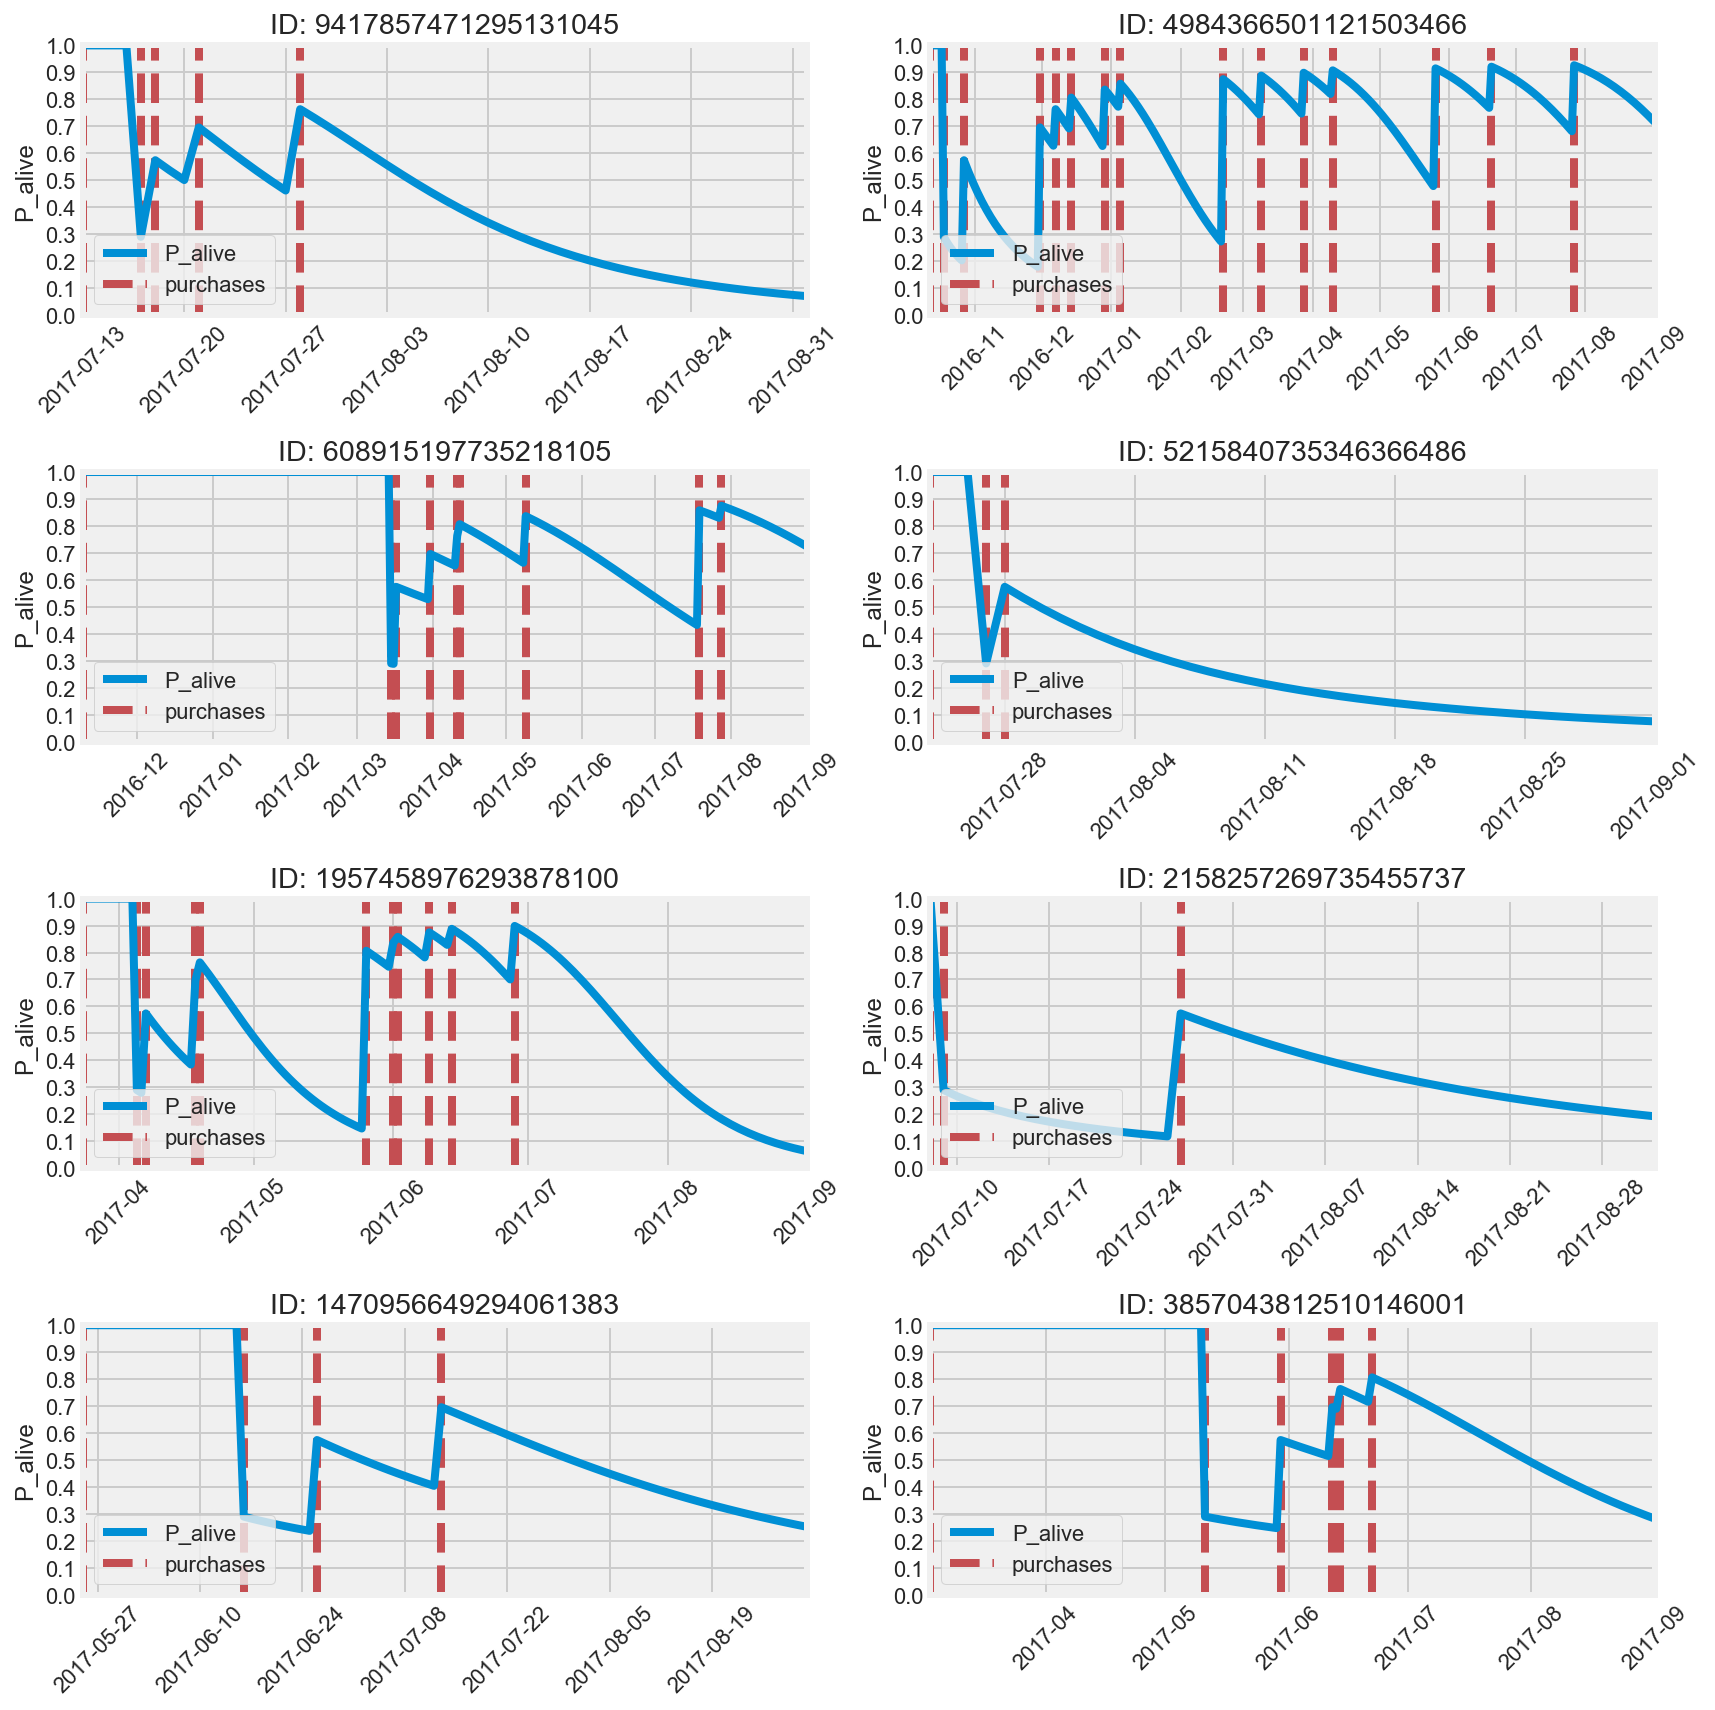

In [62]:
fig = plt.figure(figsize=(12,12))
for ind,user in enumerate(top_8.index.tolist()):
    ax = plt.subplot(4,2,ind+1)
    best_T = rfm.loc[user,'T']+31 #add a month
    best_trans = conversions[conversions['fullVisitorId'] == user]
    plot_history_alive(bgf, int(best_T), best_trans, 'date', freq='D', ax=ax)
    ax.set_title('ID: '+str(user))
    plt.xticks(rotation=45)
fig.tight_layout()

# Who are our best customers? 

In [64]:
rfm['rank'] = pd.qcut(rfm['predicted_purchases'], 4, labels=[4,3,2,1])
cust_ranks = rfm['rank']
customer_analysis = customers[customers['visitSequence']==1]
customer_analysis = customer_analysis[['fullVisitorId','browser','isMobile','country','channelGrouping']]

In [65]:
customer_analysis = customer_analysis[~customer_analysis.duplicated()]

In [66]:
customer_analysis['rank'] = customer_analysis['fullVisitorId'].map(cust_ranks)
customer_features = pd.get_dummies(customer_analysis, columns=['channelGrouping'], drop_first=True)
X = customer_features.drop(['fullVisitorId','rank','isMobile','country','browser'],axis=1)
y = customer_features['rank']

In [67]:
def plot_tree(crit, split, depth, min_split, min_leaf=0.2, min_decrease=0.001):
    estimator = DecisionTreeClassifier(random_state = 0
        , criterion=crit
        , splitter = split
        , max_depth = depth
        , min_samples_split=min_split
        , min_samples_leaf=min_leaf
        , min_impurity_decrease = min_decrease)
    estimator.fit(X, y)
    graph = Source(tree.export_graphviz(estimator
          , out_file=None
          , feature_names=X.columns
          , class_names=[str(c) for c in estimator.classes_]
          , filled = True))
    display(SVG(graph.pipe(format='svg')))
    return estimator

inter=interactive(plot_tree
   , crit = ["gini", "entropy"]
   , split = ["best"]
   , depth=np.linspace(1, 35, 35, endpoint=True)
   , min_split=np.linspace(.0001, .5, 100)
   , min_leaf=np.linspace(.0001, .5, 100)
   , min_decrease=np.linspace(.0001, .01, 100)
)
display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

In [68]:
customer_analysis['first_touch'] = customer_analysis['fullVisitorId'].map(firstchannel)

In [69]:
best_channel = customer_analysis[customer_analysis['rank']==1]['first_touch'].value_counts()
best_channel.name = 'top_ranking'
channels = train_df['first_touch'].value_counts()
channels = pd.concat([channels,best_channel],axis=1)

Text(0.5,0,'Channel')

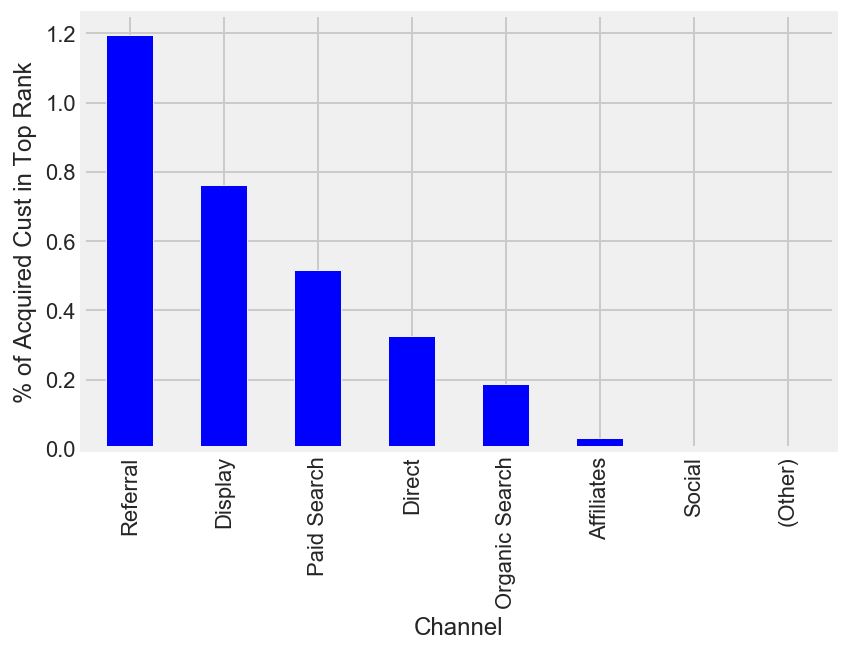

In [70]:
(100*(channels.top_ranking/ channels.first_touch)).sort_values(ascending=False).plot(kind='bar', color='blue')
plt.ylabel('% of Acquired Cust in Top Rank')
plt.xlabel('Channel')

In [71]:
country_rank = customer_analysis[customer_analysis['rank']==1]['country'].value_counts()
country_rank.name = 'rank'
country = customer_analysis['country'].value_counts()
country = pd.concat([country_rank, country],axis=1)
country.dropna(inplace=True)

In [72]:
country = country[country['country']>10]

Text(0.5,0,'Country')

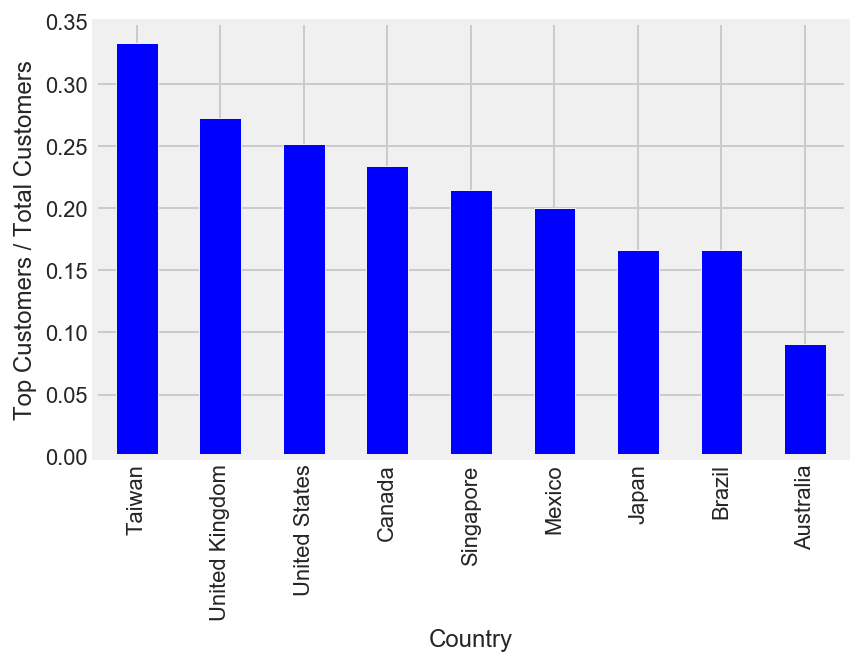

In [73]:
(country['rank']/country['country']).sort_values(ascending=False).plot(kind='bar', color='blue')
plt.ylabel('Top Customers / Total Customers')
plt.xlabel('Country')

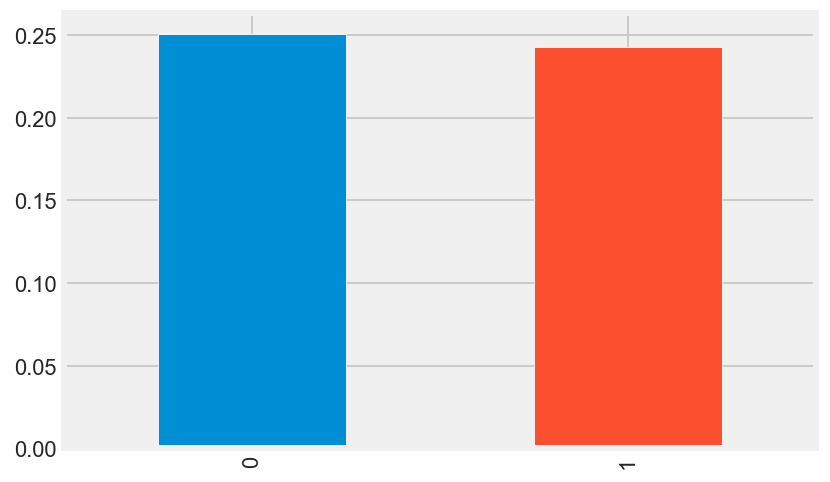

In [74]:
mobile_rank = customer_analysis[customer_analysis['rank']==1]['isMobile'].value_counts()
mobile_rank.name = 'rank'
mobile = customer_analysis['isMobile'].value_counts()
mobile = pd.concat([mobile_rank, mobile],axis=1)
(mobile['rank']/mobile['isMobile']).plot(kind='bar')

# Gamma Gamma

### All customers

In [75]:
ggf = GammaGammaFitter(penalizer_coef = 0.0005)
ret_cust_data = rfm[rfm['frequency'] > 0]
ret_cust_data['monetary_value'] = ret_cust_data['monetary_value']*0.70 # Set Monetary value to gross profit only
ggf.fit(ret_cust_data['frequency'], ret_cust_data['monetary_value'])
p,q,v = ggf._unload_params('p', 'q', 'v')
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 720 subjects, p: 5.25, q: 0.91, v: 6.32>


In [76]:
avg_cond_profit = ggf.conditional_expected_average_profit(ret_cust_data['frequency'], ret_cust_data['monetary_value'])

In [77]:
def RCV(t, model_trans, d, rfm, zeta):
    discount_factor = 1./(1+d)**t
    dif = (model_trans.conditional_expected_number_of_purchases_up_to_time(t*30, rfm['frequency'], rfm['recency'], rfm['T'])
        - model_trans.conditional_expected_number_of_purchases_up_to_time((t-1)*30, rfm['frequency'], rfm['recency'], rfm['T']))
    return ((dif*zeta).sum())*discount_factor

def approximate(fn, t=1, eps_tol=1e-6, eps=0, **kwargs):
    eps = 0
    cf = 0
    while True:
        cf += fn(t=t, **kwargs)
        if(cf - eps < eps_tol):
            break
        eps = cf; t+=1
    return cf

dr = 0.15 #annual discount
mr = (1+dr)**(1/12.)-1. #monthly rate
customer_scale = p*(v+ret_cust_data['frequency']*ret_cust_data['monetary_value'])
customer_shape = p*ret_cust_data['frequency']+q
ez = customer_scale/(customer_shape-1)
residual_value = approximate(RCV, model_trans=bgf, d=mr, rfm=ret_cust_data, zeta=ez)
print('Residual Customer Value: $%.2f' % residual_value)

Residual Customer Value: $142817.31


Text(0.5,0,'Purchase Value')

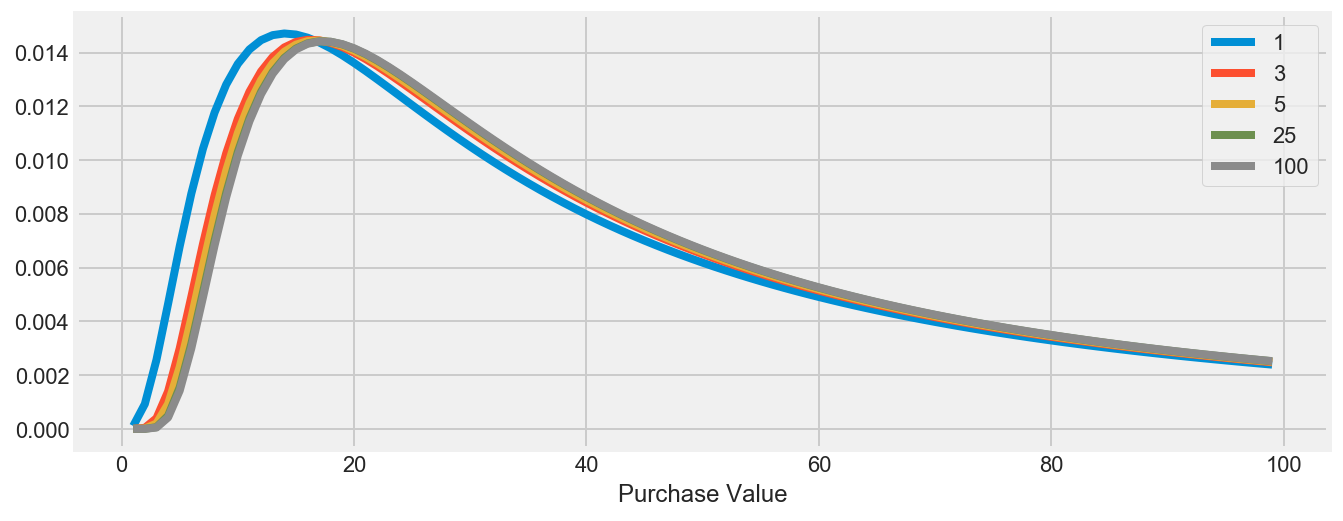

In [83]:
from scipy.special import beta
def pzbar(zbar,p,q,v,x):
    return (1./(zbar*beta(p*x,q)))*((v/(v+x*zbar))**(q))*(((x*zbar)/(v+x*zbar))**(p*x))

x = range(1,100)
numtrans = [1,3,5,25,100]
dist = pd.DataFrame(0,index=x, columns=numtrans)
for j in range(0,5):
    for i in x:
        dist.loc[i,numtrans[j]] = pzbar(i, p,q,v,numtrans[j])
dist.plot(figsize=(10,4))
plt.xlabel('Purchase Value')

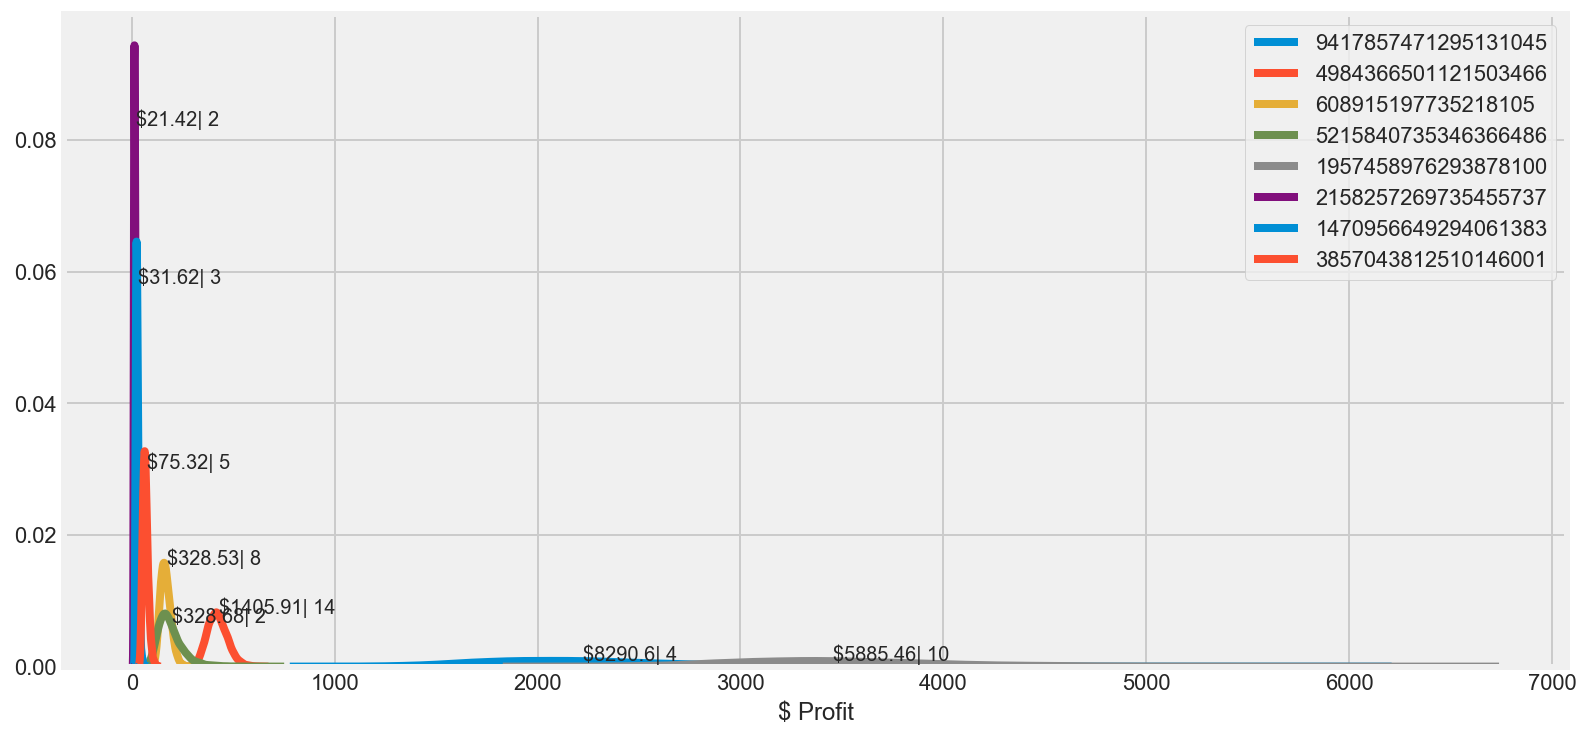

In [82]:
customer_scale = p*(v+ret_cust_data['frequency']*ret_cust_data['monetary_value'])
customer_shape = p*ret_cust_data['frequency']+q
ez = customer_scale/(customer_shape-1)
top_8['predicted_purchase_value'] = top_8['predicted_purchases']*ez
plt.figure(figsize=(12,6))
plt.xlabel('$ Profit')
for ind,i in enumerate(top_8.index.tolist()):
    ccig = invgamma.rvs(customer_shape[i], scale=customer_scale[i], size = 10000)
    plt.text(ez[i]+5, invgamma.pdf(ez[i], customer_shape[i], scale=customer_scale[i]),
             '$'+str(round(top_8['predicted_purchase_value'][i],2))
            +'| '+str(int(ret_cust_data.loc[i,'frequency'])))
    sns.distplot(ccig, hist=False, rug=False, label=str(i));

# Channel Normalized NPV Scores

In [147]:
channel_value = {
    'Organic Search':[],
    'Paid Search':[],
    'Display':[],
    'Referral':[],
    'Direct':[]
}

In [148]:
for channel in list(channel_value.keys()):  
    channel_conversions = train_df[(train_df['conversion']==1)&(train_df['first_touch']==channel)].sort_values(['fullVisitorId','date'])
    channel_conversions = channel_conversions.groupby(['fullVisitorId','date','sessionId'])['transactionRevenue'].sum()
    channel_conversions = channel_conversions.reset_index()
    channel_conversions.sort_values('date',inplace=True)
    channel_orders = channel_conversions.groupby(['fullVisitorId','date']).transactionRevenue.sum().reset_index()
    channel_rfm = summary_data_from_transaction_data(channel_orders, 
                                       customer_id_col='fullVisitorId', 
                                       datetime_col='date', 
                                       monetary_value_col='transactionRevenue', 
                                       observation_period_end='2017-08-01')
    channel_ggf = GammaGammaFitter(penalizer_coef = 0.001)
    channel_ret_cust_data = channel_rfm[channel_rfm['frequency'] > 0]
    channel_ret_cust_data['monetary_value'] = channel_ret_cust_data['monetary_value']*0.70 # Set Monetary value to gross profit only
    ggf.fit(channel_ret_cust_data['frequency'], channel_ret_cust_data['monetary_value'])
    channel_p,channel_q,channel_v = ggf._unload_params('p', 'q', 'v')
    print(channel_ggf)
    channel_customer_scale = channel_p*(channel_v+channel_ret_cust_data['frequency']*channel_ret_cust_data['monetary_value'])
    channel_customer_shape = channel_p*channel_ret_cust_data['frequency']+channel_q
    channel_ez = channel_customer_scale/(channel_customer_shape-1)
    channel_residual_value = approximate(RCV, model_trans=bgf, d=mr, rfm=channel_ret_cust_data, zeta=channel_ez)
    print('Residual %s Value: $%.2f' % (channel,channel_residual_value))
    print('Number of return customers from {0}: {1}'.format(channel,len(channel_ret_cust_data)))
    print('Normalized {0} NPV: {1}'.format(channel,channel_residual_value/(1.0*len(channel_ret_cust_data))))
    channel_value[channel].append(channel_residual_value/(1.0*len(channel_ret_cust_data)))
    channel_value[channel].append(channel_residual_value)
    
channel_npv = pd.DataFrame(channel_value).T
channel_npv.columns = ['norm','npv']

<lifetimes.GammaGammaFitter>
Residual Organic Search Value: $44005.47
Number of return customers from Organic Search: 158
Normalized Organic Search NPV: 278.5156474857887
<lifetimes.GammaGammaFitter>
Residual Paid Search Value: $1185.90
Number of return customers from Paid Search: 22
Normalized Paid Search NPV: 53.904388086966975
<lifetimes.GammaGammaFitter>
Residual Display Value: $268.69
Number of return customers from Display: 13
Normalized Display NPV: 20.668691328455473
<lifetimes.GammaGammaFitter>
Residual Referral Value: $25740.57
Number of return customers from Referral: 352
Normalized Referral NPV: 73.1266248886563
<lifetimes.GammaGammaFitter>
Residual Direct Value: $72525.20
Number of return customers from Direct: 173
Normalized Direct NPV: 419.22079484878174


Text(0,0.5,'Average NPV per return Customer in $')

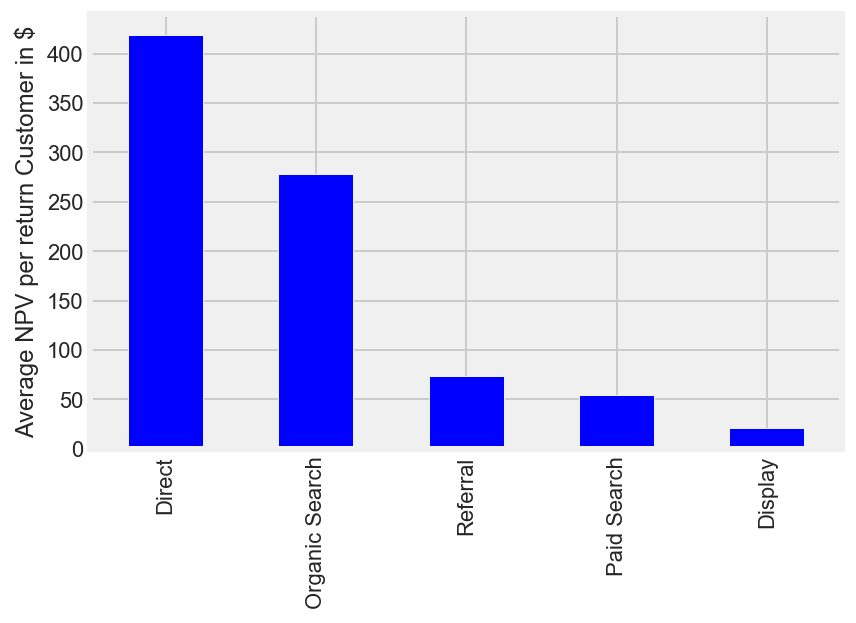

In [151]:
channel_npv['norm'].sort_values(ascending=False).plot(kind='bar', color='blue')
plt.ylabel('Average NPV per return Customer in $')

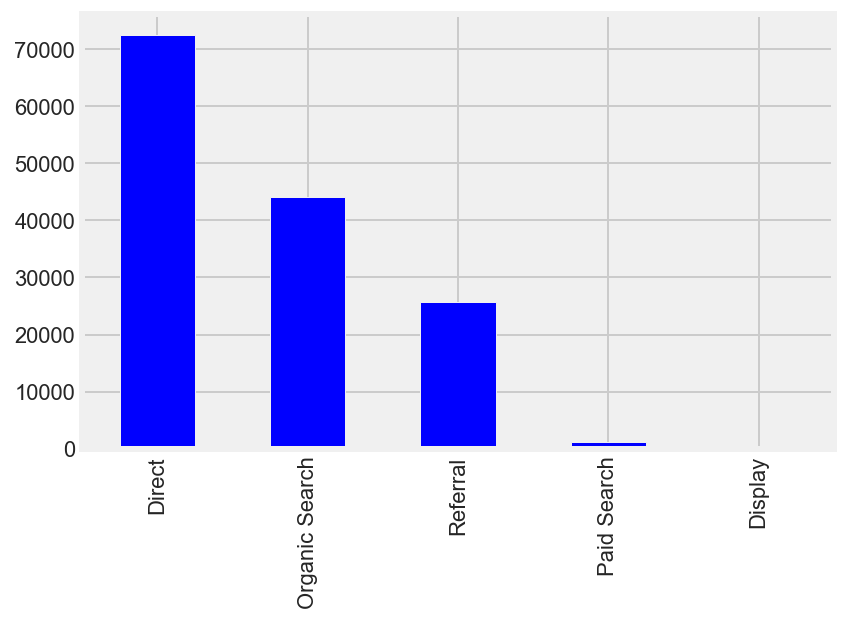

In [150]:
channel_npv['npv'].sort_values(ascending=False).plot(kind='bar', color='blue')

# Forecasting with Prophet

In [77]:
revenue = conversions[['fullVisitorId','date','transactionRevenue']]
revenue = revenue[revenue['date']<pd.to_datetime('2017-08-01')]
revenue = revenue.set_index('date').resample('D')['transactionRevenue'].sum()
revenue = revenue.reset_index()
revenue.columns = ['ds','y']
revenue['y'] = revenue['y'].rolling(window=7).mean()
revenue.dropna(inplace=True)

In [78]:
data = [go.Scatter(x=revenue.ds, 
               y=revenue.y, 
               name = 'Daily Rolling Revenue',
               mode = 'lines',
              )]

layout = dict(
    title='Time Series with Rangeslider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename = "Time Series with Rangeslider")

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

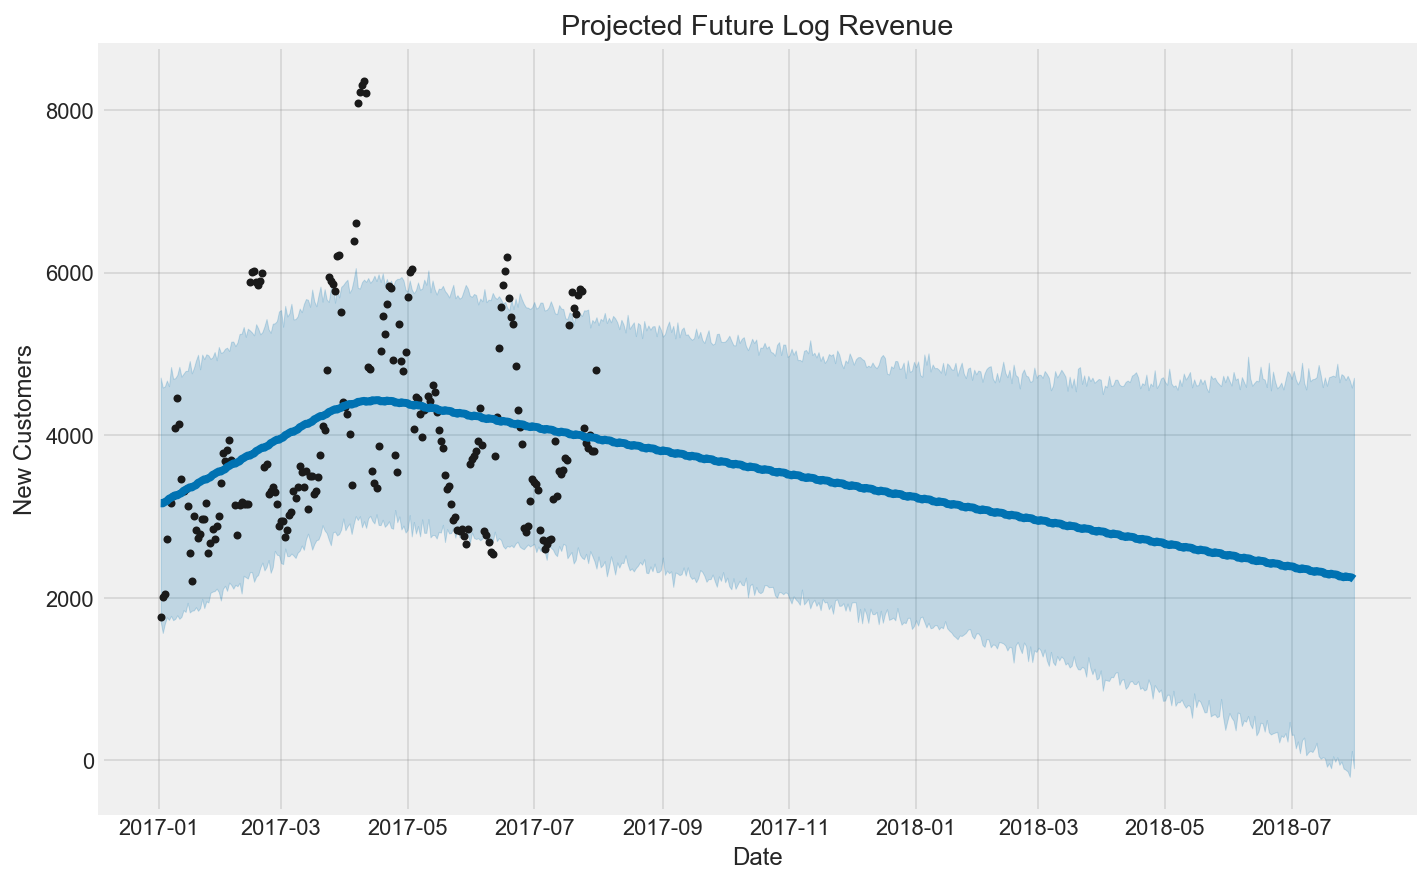

In [79]:
new_prophet = Prophet()
new_prophet.fit(revenue[revenue['ds']>pd.to_datetime('2017-01-01')])
forecast = new_prophet.make_future_dataframe(periods=365, freq='D')
forecast = new_prophet.predict(forecast)
plt.figure(figsize=(18, 6))
new_prophet.plot(forecast, xlabel = 'Date', ylabel = 'New Customers')
plt.title('Projected Future Log Revenue');

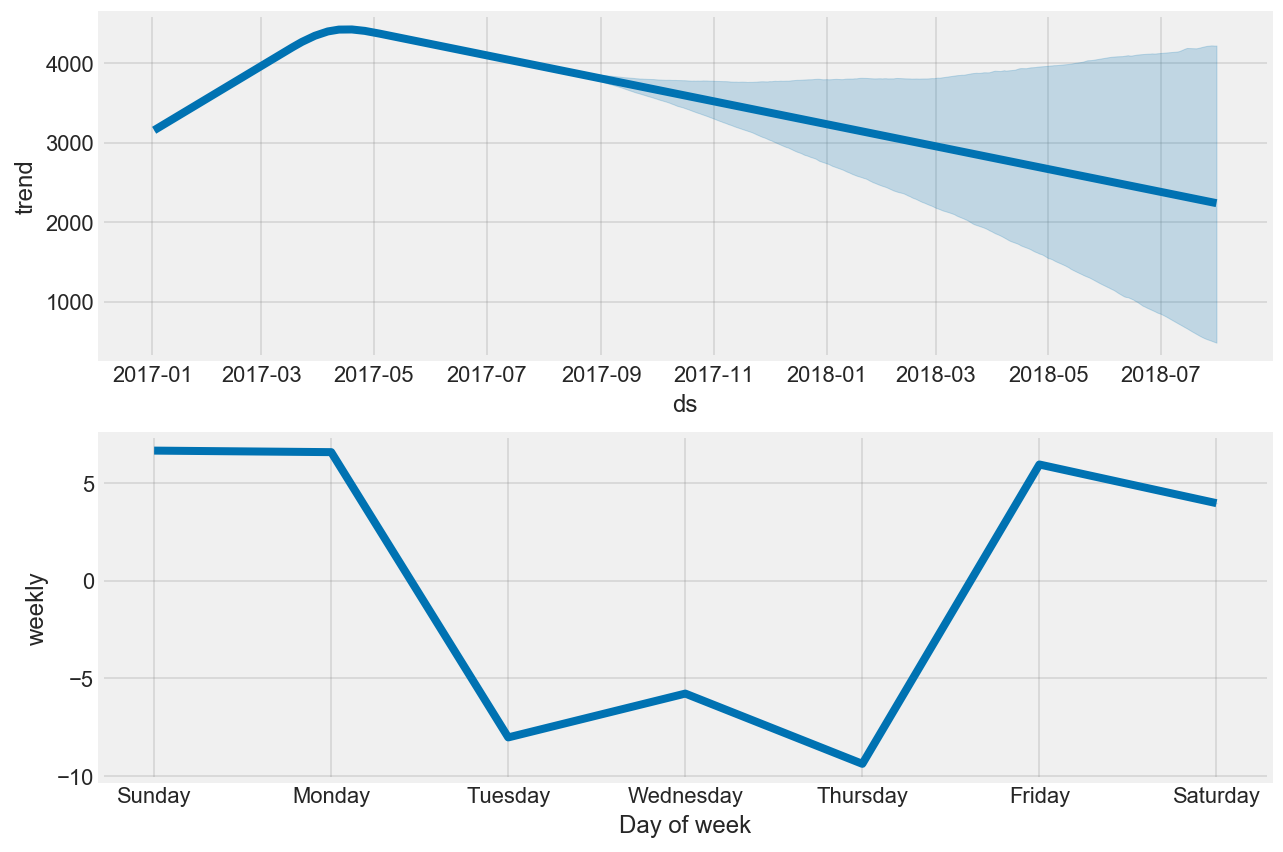

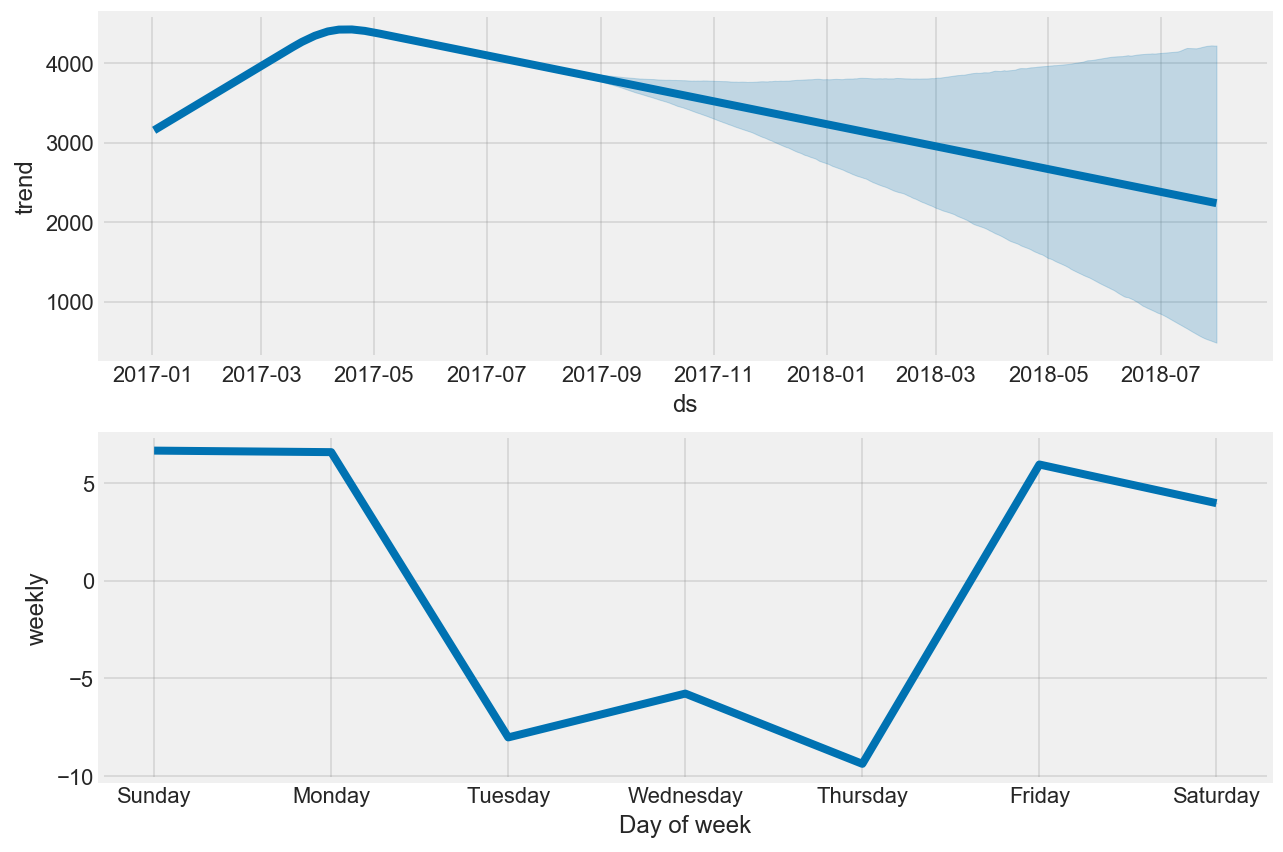

In [80]:
new_prophet.plot_components(forecast)